In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC, SparseCategoricalAccuracy
import time


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import movmus as mm
import movmus2 as mm2

import json

## LOADING DATA

In [2]:
train_data, val_data, test_data = mm.load_data_npz('EMG_6337_data.npz')

shape of training data: (2720, 6337, 7)
shape of validation data: (502, 6337, 7)
shape of test data: (661, 6337, 7)


In [3]:
train_labels = mm.load_labels('training_labels.npz')
val_labels = mm.load_labels('validation_labels.npz')
test_labels = mm.load_labels('test_labels.npz')
print('train labels:', train_labels.shape, 'val labels:', val_labels.shape, 'test labels:', test_labels.shape)

train labels: (2720, 2) val labels: (502, 2) test labels: (661, 2)


In [4]:
train_labels.head()

,ID,GRASP_DH
0,1.0,1.0
1,2.0,1.0
2,3.0,1.0
3,4.0,1.0
4,5.0,1.0


In [5]:
train_labels_categorical = mm.adjust_labels(train_labels)
val_labels_categorical = mm.adjust_labels(val_labels)
test_labels_categorical = mm.adjust_labels(test_labels)
print('train labels:', train_labels_categorical.shape, 'val labels:', val_labels_categorical.shape, 'test labels:', test_labels_categorical.shape)

Labels after one-hot encoding: (2720, 2)
Labels after one-hot encoding: (502, 2)
Labels after one-hot encoding: (661, 2)
train labels: (2720, 2) val labels: (502, 2) test labels: (661, 2)


In [6]:
print(train_labels_categorical) 

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [7]:
first_column = train_labels_categorical[:, 0]
#print(first_column)
second_column = train_labels_categorical[:, 1]
# Count the number of 0s
count_first = np.count_nonzero(first_column == 1)

# Calculate the percentage
percentage_first = (count_first / len(first_column)) * 100

print(f"Percentage of 1s in the first column: {percentage_first}%")

count_second = np.count_nonzero(second_column == 1)
percentage_second = (count_second / len(second_column)) * 100
print(f"Percentage of 1s in the second column: {percentage_second}%")

Percentage of 1s in the first column: 61.360294117647065%
Percentage of 1s in the second column: 38.63970588235294%


## MODEL CREATION

In [58]:
from tensorflow.keras.regularizers import l2

In [59]:
model_name = 'M_1_6337'
model_folder = '.\\MODELS_6337'
plot_folder = '.\\PLOTS_6337'

In [60]:
num_samples = len(train_data)  # Number of training samples
print("Number of training samples:", num_samples)
possible_batch_sizes = [i for i in range(1, num_samples + 1) if num_samples % i == 0]

print("Possible batch sizes that divide evenly:", possible_batch_sizes)

Number of training samples: 2720
Possible batch sizes that divide evenly: [1, 2, 4, 5, 8, 10, 16, 17, 20, 32, 34, 40, 68, 80, 85, 136, 160, 170, 272, 340, 544, 680, 1360, 2720]


In [61]:
batch_size = 85
epochs = 300

In [62]:
# Define the learning rate schedule
initial_learning_rate = 0.001
decay_steps = (num_samples/batch_size)*epochs  # 2752 samples/ 86 bs = 32 --> 32 * 250 epochs = 8000 steps
print("Decay steps:", decay_steps)
alpha = 0.01 

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=alpha
)

Decay steps: 9600.0


In [63]:
from tensorflow.keras.callbacks import Callback

class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f" - lr: {lr}")


In [64]:
model = Sequential([
    # Layer 1
    tf.keras.layers.Conv1D(filters=16, kernel_size=10, padding='valid', activation='relu', input_shape=(6337, 7)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # Layer 2
    tf.keras.layers.Conv1D(filters=32, kernel_size=10, padding='valid', activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.2),

    # Layer 3
    tf.keras.layers.Dense(32, activation='relu'),

    # Exit layer
    tf.keras.layers.Dense(2, activation='softmax')
])

c:\Users\al385931\AppData\Local\anaconda3\envs\tfm2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=['accuracy', Precision(), Recall()] 
)



In [66]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 6328, 16)       │         1,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6328, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3164, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3155, 32)       │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3155, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,602 (29.70 KB)

 Trainable params: 7,506 (29.32 KB)

 Non-trainable params: 96 (384.00 B)

## TRAINING

In [67]:
tf.keras.config.disable_traceback_filtering()


In [68]:
start_time = time.time()

# Train the model
history = model.fit(
    train_data, train_labels_categorical,
    validation_data=(val_data, val_labels_categorical),
    epochs=epochs,  
    batch_size=batch_size,
    callbacks=[LearningRateLogger()],  
    verbose=1)
    #class_weight = class_weight_dict
#)

end_time = time.time()

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6494 - loss: 0.6564 - precision_3: 0.6494 - recall_3: 0.6494 - lr: 0.0009999729227274656
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6515 - loss: 0.6553 - precision_3: 0.6515 - recall_3: 0.6515 - val_accuracy: 0.5339 - val_loss: 0.6906 - val_precision_3: 0.5339 - val_recall_3: 0.5339
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7823 - loss: 0.5290 - precision_3: 0.7823 - recall_3: 0.7823 - lr: 0.0009998914320021868
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7823 - loss: 0.5284 - precision_3: 0.7823 - recall_3: 0.7823 - val_accuracy: 0.5339 - val_loss: 0.7266 - val_precision_3: 0.5339 - val_recall_3: 0.5339
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7810 - loss: 0.4884 - precision_3: 0.7810 - recall_3: 0.7810 - lr: 0.0009997556917369366
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7814 - loss: 0.4879 - precision_3: 0.7814 - recall_3: 0.7814 - 

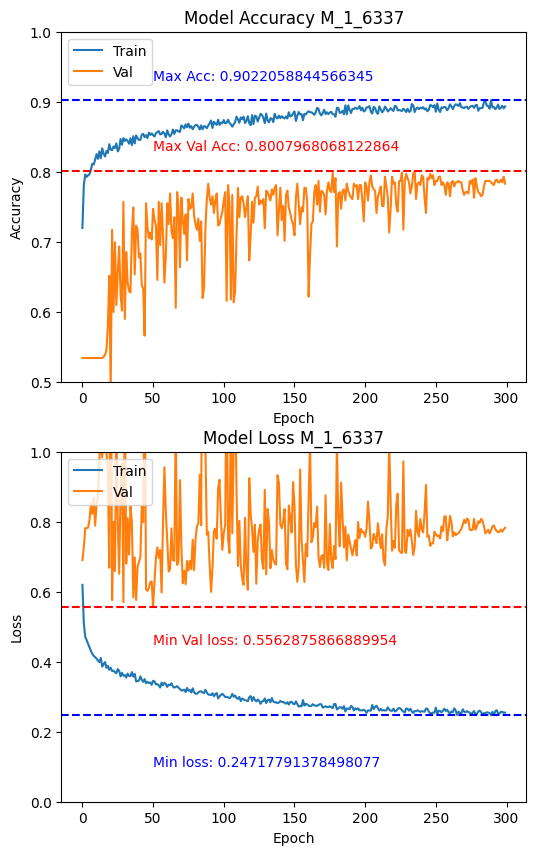

In [69]:
fig, axs = plt.subplots(2,1, figsize=(6, 10))
    
# Subplot 1: Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy ' + model_name)

axs[0].axhline(y=max(history.history['accuracy']), color='b', linestyle='--')  # Add horizontal line at y=0.75
axs[0].text(50,0.93, f'Max Acc: {max(history.history["accuracy"])}', color='b')  # Add text annotation with the max value

axs[0].axhline(y=max(history.history['val_accuracy']), color='r', linestyle='--')  # Add horizontal line at y=0.75
axs[0].text(50,0.83, f'Max Val Acc: {max(history.history["val_accuracy"])}', color='red')  # Add text annotation with the max value
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[0].set_ylim(0.5, 1)

# Subplot 2: Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss ' + model_name)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')
axs[1].set_ylim(0, 1)

axs[1].axhline(y=min(history.history['val_loss']), color='r', linestyle='--')  # Add horizontal line at y=0.75
axs[1].text(50,0.45, f'Min Val loss: {min(history.history["val_loss"])}', color='red')  # Add text annotation with the max value

axs[1].axhline(y=min(history.history['loss']), color='b', linestyle='--')  # Add horizontal line at y=0.75
axs[1].text(50,0.1, f'Min loss: {min(history.history["loss"])}', color='b')  # Add text annotation with the max value

# Save the figure with subplots
plt.savefig(f'{plot_folder}\\ACC_LOSS_{model_name}.png')

# Show the plot
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


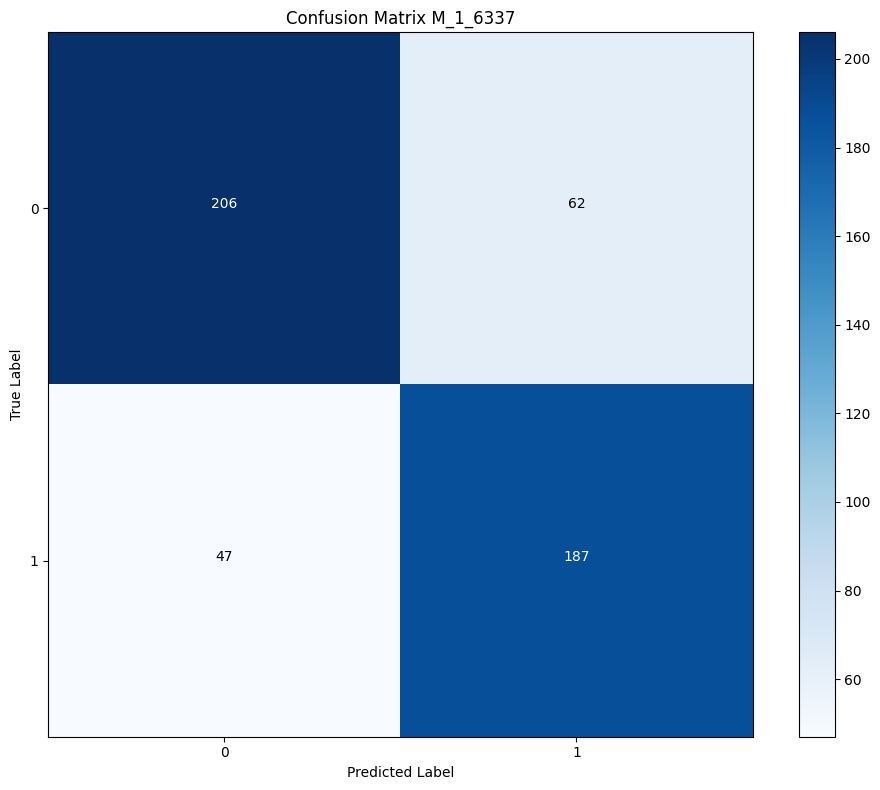

In [70]:
#import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

# Assuming y_val is one-hot encoded, convert it back to class labels
y_true_classes = np.argmax(val_labels_categorical, axis=1)

# Make predictions on the validation set
y_pred = model.predict(val_data)

# Convert predictions from sigmoid output to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cmap = plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix ' + model_name)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true_classes)))  # this adapts to the number of classes dynamically
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Labeling the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig(f'{plot_folder}\\CM_{model_name}.png')

plt.show()


In [71]:
mm.save_model(model, model_folder, model_name)

Model saved to .\MODELS_6337\M_1_6337.keras


In [72]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")
print('training time:', (training_time/60), 'minutes')
# Convert the history object to a dictionary
history_dict = history.history

# Add the training time to the dictionary
history_dict['training_time'] = training_time
history_dict['model'] = model_name
history_dict['batch_size'] = batch_size
history_dict['epochs'] = epochs
history_dict['learning_rate'] = initial_learning_rate
history_dict['decay_steps'] = decay_steps
history_dict['alpha'] = alpha
history_dict['loss_function'] = 'binary_crossentropy'
history_dict['optimizer'] = 'Adam'

# Save the dictionary to a JSON file
mm.save_history(history_dict, model_folder, model_name)

Training time: 1249.6577022075653 seconds
training time: 20.82762837012609 minutes
History saved to .\MODELS_6337\M_1_6337_history.json


In [73]:

print('output shape')
print(y_pred.shape)
print('output')
print(y_pred)

output shape
(502, 2)
output
[[1.91418675e-03 9.98085856e-01]
 [3.92831280e-05 9.99960661e-01]
 [8.95367877e-11 1.00000000e+00]
 ...
 [9.98865366e-01 1.13462226e-03]
 [8.84000897e-01 1.15999125e-01]
 [9.96666253e-01 3.33379698e-03]]


## changing axis


In [24]:
models = ['M_1_6337']

Loading model from .\MODELS_6337\M_1_6337.keras
Num Layers: 9
----
----
Layer: conv1d_2
{
    "name": "conv1d_2",
    "trainable": true,
    "dtype": {
        "module": "keras",
        "class_name": "DTypePolicy",
        "config": {
            "name": "float32"
        },
        "registered_name": null
    },
    "filters": 16,
    "kernel_size": [
        10
    ],
    "strides": [
        1
    ],
    "padding": "valid",
    "data_format": "channels_last",
    "dilation_rate": [
        1
    ],
    "groups": 1,
    "activation": "relu",
    "use_bias": true,
    "kernel_initializer": {
        "module": "keras.initializers",
        "class_name": "GlorotUniform",
        "config": {
            "seed": null
        },
        "registered_name": null
    },
    "bias_initializer": {
        "module": "keras.initializers",
        "class_name": "Zeros",
        "config": {},
        "registered_name": null
    },
    "kernel_regularizer": null,
    "bias_regularizer": null,
    "

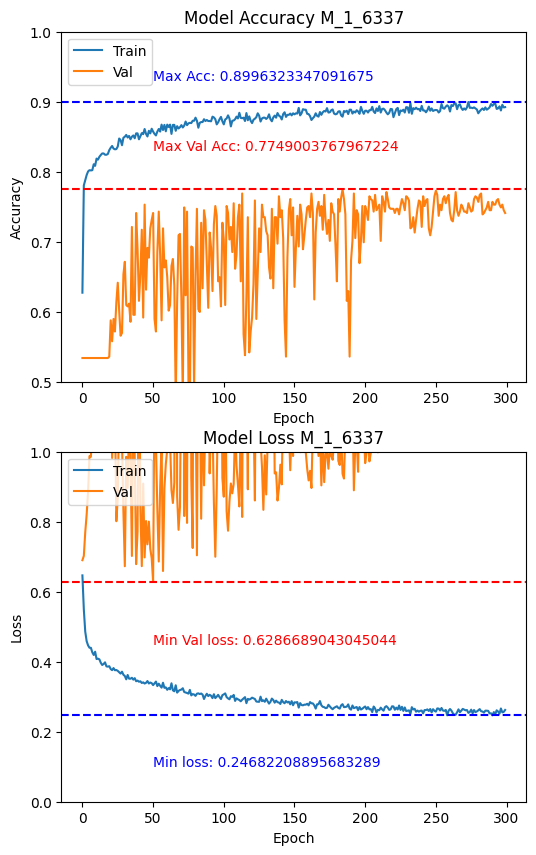

In [25]:
for model in models:
    #m = tf.keras.models.load_model(f'.\\MODELS\\{model}.keras')
    m = mm.load_model(model_folder, model)
    history = mm.load_history(model_folder, model)
    fig, axs = plt.subplots(2,1, figsize=(6, 10))
        
    # Subplot 1: Plot training & validation accuracy values
    axs[0].plot(history['accuracy'])
    axs[0].plot(history['val_accuracy'])
    axs[0].set_title('Model Accuracy ' + model)

    axs[0].axhline(y=max(history['accuracy']), color='b', linestyle='--')  # Add horizontal line at y=0.75
    axs[0].text(50,0.93, f'Max Acc: {max(history["accuracy"])}', color='b')  # Add text annotation with the max value

    axs[0].axhline(y=max(history['val_accuracy']), color='r', linestyle='--')  # Add horizontal line at y=0.75
    axs[0].text(50,0.83, f'Max Val Acc: {max(history["val_accuracy"])}', color='red')  # Add text annotation with the max value
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')
    axs[0].set_ylim(0.5, 1)

    # Subplot 2: Plot training & validation loss values
    axs[1].plot(history['loss'])
    axs[1].plot(history['val_loss'])
    axs[1].set_title('Model Loss ' + model)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')
    axs[1].set_ylim(0, 1)

    axs[1].axhline(y=min(history['val_loss']), color='r', linestyle='--')  # Add horizontal line at y=0.75
    axs[1].text(50,0.45, f'Min Val loss: {min(history["val_loss"])}', color='red')  # Add text annotation with the max value

    axs[1].axhline(y=min(history['loss']), color='b', linestyle='--')  # Add horizontal line at y=0.75
    axs[1].text(50,0.1, f'Min loss: {min(history["loss"])}', color='b')  # Add text annotation with the max value

    # Save the figure with subplots
    #plt.savefig(f'{plot_folder}\\ACC_LOSS_{model}.png')

    # Show the plot
    plt.show()